In [23]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from pprint import pprint

from tiled.client import from_uri
import matplotlib.pyplot as plt
import matplotlib as mpl

In [25]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
# mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

# Basic Tutorial

The [AIMM post-processing pipeline](https://github.com/AI-multimodal/aimm-post-processing) is built around the `Operator` object. The `Operator`'s job is to take a `client`-like object and execute a post-processing operation on it. The specific type of operation is defined by the operator. All metadata/provenance is tracked.

In [26]:
from aimmdb.postprocessing import operations

Connect to the `tiled` client. This one is the [aimmdb](https://github.com/AI-multimodal/aimmdb) hosted at [aimm.lbl.gov](https://aimm.lbl.gov/api). Note that my API key is stored in an environment variable, `TILED_API_KEY`. 

In [27]:
CLIENT = from_uri("https://aimm.lbl.gov/api")

ClientError: 404: Not Found https://aimm.lbl.gov/api/v1/

In [8]:
list(CLIENT["dataset"])

['newville']

## Unary operators

A [unary operator](https://en.wikipedia.org/wiki/Unary_operation) takes a single input. This input specifically refers to the fact that these operators only act on a single data point (meaning a `DataFrameClient`) at a time. We'll provide some examples here.

First, lets get a single `DataFrameClient` object:

In [9]:
df_client = CLIENT["uid"]["Bt5hUbgkfzR"]

tiled.client.dataframe.DataFrameClient

### The identity

The simplest operation we can perform is nothing! Let's see what it does. First, feel free to print the output of the `df_client` so you can see what's contained. Using the `read()` method will allow you to access the actual data, and the `metadata` property will allow you to access the metadata:

In [10]:
_ = df_client.read()    # is a pandas.DataFrame
_ = df_client.metadata  # is a python dictionary

The identity operator is instantiated and then run on the `df_client`.

In [11]:
op = operations.Identity()
result = op(df_client)

Every result of any operator will be a dictionary with two keys: `"data"` and `"metadata"`, which correspond to the results of `read()` and `metadata` above. The data is the correspondingly modified `pandas.DataFrame` object (which in the case of the identity, is of course the same as what we started with). The metadata is custom created for a derived, post-processed object.

First, let's check that the original and "post-processed" data are the same.

In [12]:
assert (df_client.read() == result["data"]).all().all()

Next, the metadata:

In [13]:
result["metadata"]

{'_tiled': {'uid': '42sfd6fukkR'},
 '_post_processing': {'parents': ['Bt5hUbgkfzR'],
  'operator': {'@module': 'aimmdb.postprocessing.operations',
   '@class': 'Identity',
   '@version': None},
  'kwargs': {},
  'datetime': '2022-11-18 20:32:14 UTC'}}

First, a new unique id is assigned. Second, given this is a derived quantity, the previous original metadata is now gone in place of a `post_processing` key. This key contains every bit of information needed for provenance, including the parents (which is just one in the case of a unary operator), the operator details (including code version), any keyword arguments used during instantiation, and the datetime at which the opration was run. We use the [MSONable](https://pythonhosted.org/monty/_modules/monty/json.html) library to take care of most of this for us.

We can compare against the original metadata to see the differences.

In [ ]:
df_client.metadata

### Standardizing the grids

Often times (and especially for e.g. machine learning applications) we need to interpolate our spectral data onto a common grid. We can do this easily with the `StandardizeGrid` unary operator.

In [14]:
op = operations.StandardizeGrid(x0=7550.0, xf=8900.0, nx=100, x_column="energy", y_columns=["itrans"])
result = op(df_client)

Here's a visualization of what it's done:

In [15]:
d0 = df_client.read()

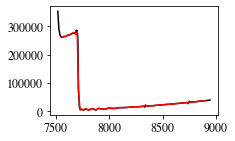

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(d0["energy"], d0["itrans"], 'k-')
ax.plot(result["data"]["energy"], result["data"]["itrans"], 'r-')
plt.show()

### Spectral postprocessing

In order to make XAS usable, we need to do a few things. Particularly:
1. Subtract off the pre-edge trend
2. Normalize the tail region to 1

We provide tools to do this systematically. For what follows, we'll do this on a Co spectrum.

In [17]:
node = CLIENT["uid"]["Bt5hUbgkfzR"]
df = node.read()

import numpy as np
df["mutrans"] = -np.log(df["itrans"]/df['i0'])

energy = df["energy"]
mutrans = df["mutrans"]

Here's what the spectrum looks like before postprocessing:

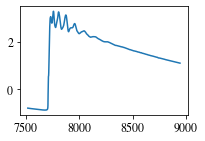

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(energy, mutrans)
plt.show()

In [19]:
remove_background = operations.RemoveBackground(x0=7510, xf=7690, y_columns=["mutrans"], victoreen_order=0)
standardize_intensity = operations.StandardizeIntensity(x0=8000, xf=None, y_columns=["mutrans"])

In [20]:
tmp_data = remove_background({'data': df, 'metadata': node.metadata})
new_data = standardize_intensity(tmp_data)

In [21]:
new_df = new_data["data"]
energy = new_df["energy"]
mutrans = new_df["mutrans"]

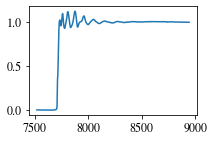

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(energy, mutrans)
plt.show()

Alternative normalization scheme using x-ray larch (see: https://xraypy.github.io/xraylarch/)

In [ ]:
normalize_xas = operations.NormalizeLarch(y_columns=["mutrans"])
larch_norm_data = normalize_xas(tmp_data)

larch_norm_df = larch_norm_data["data"]
energy = larch_norm_df["energy"]
mutrans = larch_norm_df["mutrans"]

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(energy, mutrans)
plt.show()

# Multiple input operators

MultiOperators are defined act on an arbitrary number of inputs and return a single output. Any number of `DataFrameClient` objects can be passed to a MultiOperator and acted on.

For example here we use a MultiOperator to average data from several spectra in aimmdb:

In [1]:
## trying to average all Au data -> keep getting 'data':None after StandardizeIntensity
average_data = operations.AverageData(y_column="itrans")
Au_data = CLIENT["element"]["Au"]["uid"].values()

print(Au_data[0].read())
print(Au_data[1].read())
# standardize the x-grids before averaging
standardize_intensity = operations.StandardizeIntensity(x0=14250, xf=15000, y_columns=["itrans"])
print(standardize_intensity(Au_data[0]))

Au_data = [standardize_intensity(data) for data in Au_data]

avg_result = average_data(Au_data)
avg_result["metadata"]

NameError: name 'operations' is not defined

In [ ]:
avg_data = avg_result["data"]
energy = avg_data["energy"]
mutrans = avg_data["mutrans"]

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(energy, mutrans)
plt.show()